# Example of Conditional GAN network on the MNIST (hand digit) dataset
<img src="https://i.ytimg.com/vi/71Wg3GQGyx0/maxresdefault.jpg" alt="Conditional GAN Architecture" />

Imports

In [9]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, LeakyReLU, BatchNormalization, Concatenate, Embedding, Multiply
from keras.models import Sequential, Model
try:
    from keras.optimizers.legacy import Adam
except ImportError:
    from keras.optimizers import Adam
from keras.utils import plot_model, set_random_seed
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

Load dataset and define some inputs

In [10]:
(i1, l1), (i2, l2) = mnist.load_data() # load dataset
images = np.concatenate((i1, i2)) # combine training and testing images so we have more data
labels = np.concatenate((l1, l2)) # combine training and testing labels so we have more data
img_shape = (*images.shape[1:], 1) # image shape with single channel (28x28x1)
noise_length = 128 # length of the latent vector (noise vector)
n_classes = 10 # number of classes in the mnist dataset
optimizer = Adam(0.0002, 0.5) # defining the optimizer
set_random_seed(1000) # Sets all random seeds (Python, NumPy, and backend framework, e.g. TF).

The generator network: Given input of noise (latent) vector, the Generator produces an image.

Model: "Generator_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 128)       1280        ['input_8[0][0]']                
                                                                                                  
 input_7 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 flatten_3 (Flatten)            (None, 128)          0           ['embedding_2[0][0]']            
                                                                                  

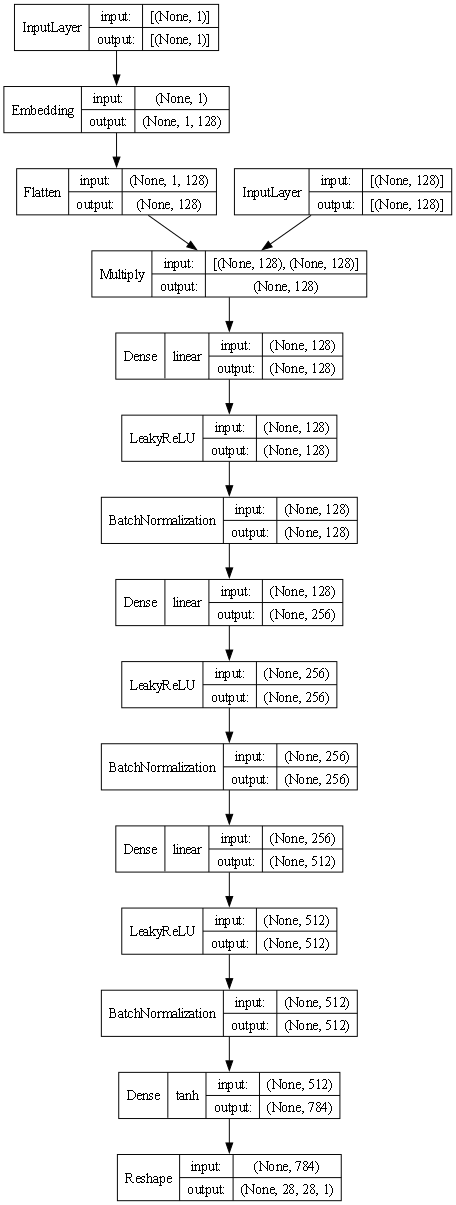

In [11]:
def build_generator():
    noise_input = Input(shape=(noise_length,))
    label_input_raw = Input(shape=(1,), dtype='int32')
    label_input = Embedding(n_classes, noise_length)(label_input_raw)
    label_input = Flatten()(label_input)
    merge_input = Multiply()([noise_input, label_input])
    out = Dense(128)(merge_input)
    out = LeakyReLU(alpha=0.2)(out)
    out = BatchNormalization(momentum=0.8)(out)
    out = Dense(256)(out)
    out = LeakyReLU(alpha=0.2)(out)
    out = BatchNormalization(momentum=0.8)(out)
    out = Dense(512)(out)
    out = LeakyReLU(alpha=0.2)(out)
    out = BatchNormalization(momentum=0.8)(out)
    out = Dense(np.prod(img_shape), activation='tanh')(out)
    out = Reshape(img_shape)(out)
    return Model([noise_input, label_input_raw], out, name="Generator_Network")

generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)
generator.summary(expand_nested=True)
plot_model(generator, show_shapes=True, expand_nested=True, show_layer_activations=True, show_layer_names=False, dpi=70)

The discriminator network: Given an input image, the Discriminator outputs the likelihood of the image being real.

Model: "Discriminator_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 784)       7840        ['input_10[0][0]']               
                                                                                                  
 flatten_4 (Flatten)            (None, 784)          0           ['input_9[0][0]']                
                                                                              

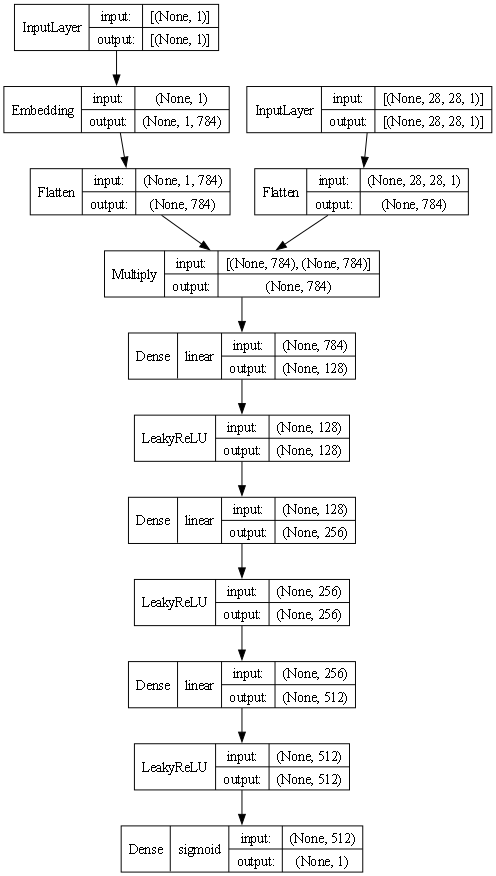

In [12]:
def build_discriminator():
    img_input = Input(shape=img_shape)
    label_input_raw = Input(shape=(1,), dtype='int32')
    label_input = Embedding(n_classes, img_shape[0]*img_shape[1])(label_input_raw)
    merge_input = Multiply()([Flatten()(img_input), Flatten()(label_input)])
    out = Dense(128)(merge_input)
    out = LeakyReLU(alpha=0.2)(out)
    out = Dense(256)(out)
    out = LeakyReLU(alpha=0.2)(out)
    out = Dense(512)(out)
    out = LeakyReLU(alpha=0.2)(out)
    out = Dense(1, activation='sigmoid')(out)
    return Model([img_input, label_input_raw], out, name="Discriminator_Network")
    
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
discriminator.summary(expand_nested=True)
plot_model(discriminator, show_shapes=True, expand_nested=True, show_layer_activations=True, show_layer_names=False, dpi=70)

-------------------------------------------------------------------
The ultimate goal here is for the Generator to fool the Discriminator.  
The combined model  (stacked generator and discriminator) takes
noise as input => generates images => determines validity

Model: "CGAN_Network"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 Generator_Network (Functional)  (None, 28, 28, 1)   588176      ['input_11[0][0]',               
                                                                  'input_12[0][0]']               
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_8 (InputLayer)         [(None, 1)]          0           []                     

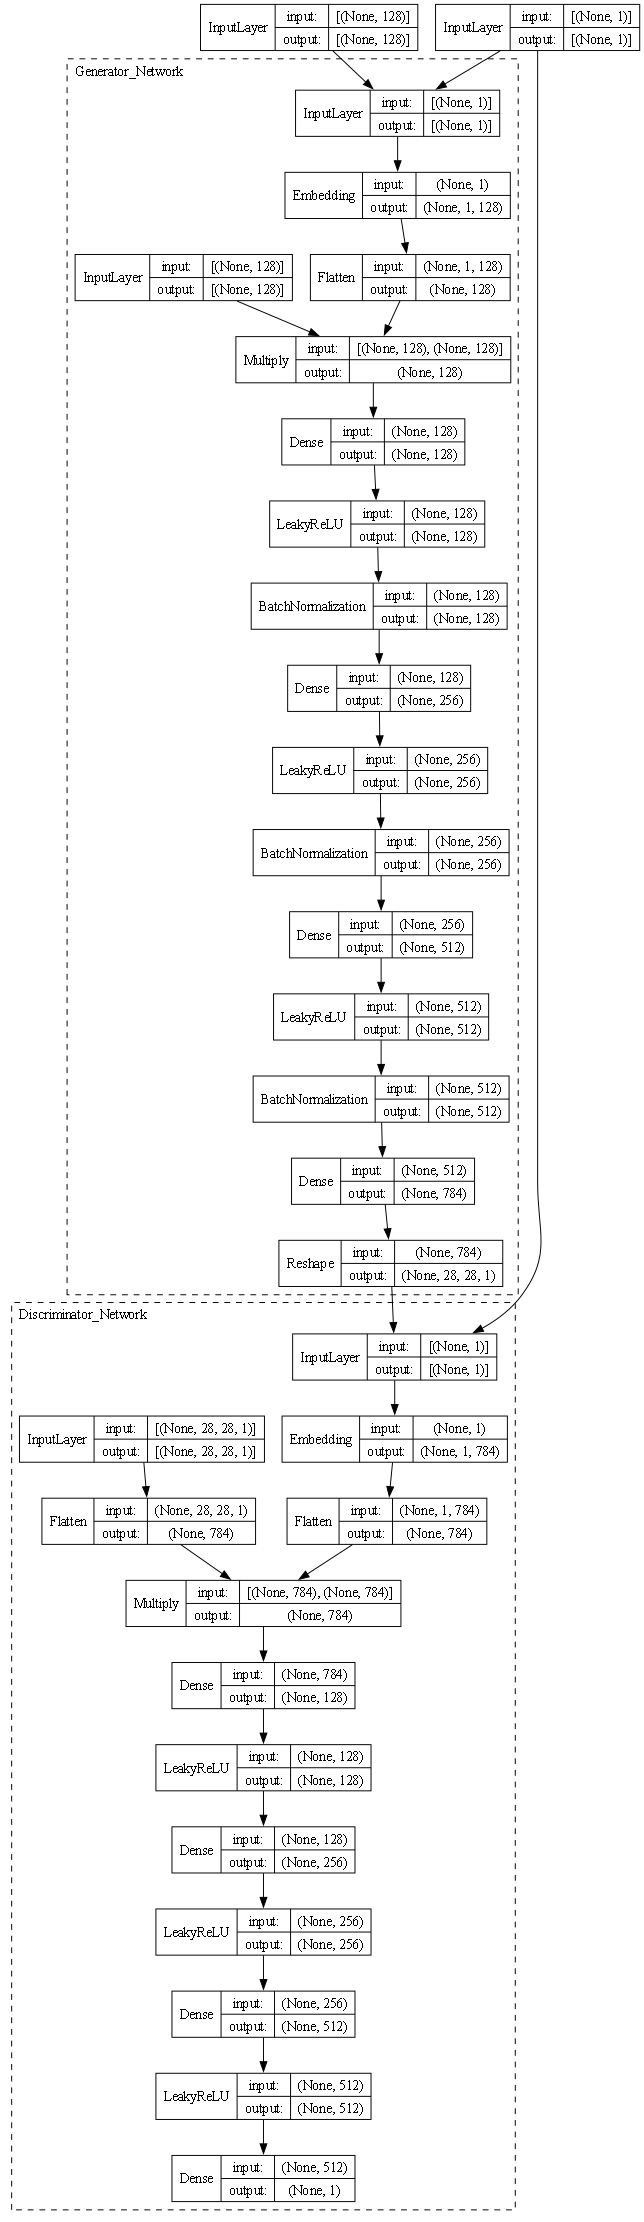

In [13]:
def build_cgan():
    noise_input = Input(shape=(noise_length,))
    label_input_raw = Input(shape=(1,), dtype='int32')
    img = generator([noise_input, label_input_raw])
    
    # While generator training we do not want discriminator weights to be trained. 
    discriminator.trainable = False  
    
    valid = discriminator([img, label_input_raw])  #Validity check on the generated image
    
    return Model([noise_input, label_input_raw], valid, name="CGAN_Network")
    
cgan = build_cgan()
cgan.compile(loss='binary_crossentropy', optimizer=optimizer)
cgan.summary(expand_nested=True)
plot_model(cgan, show_shapes=True, expand_nested=True, show_layer_activations=True, show_layer_names=False, dpi=70)

In order to train the GAN network we have to let the generator and the discriminator to compete with each other.

In [ ]:
def train(epochs, batch_size=128, plot_interval=50):
    # Convert to float and Rescale -1 to 1
    X_train = (images.astype(np.float32) - 127.5) / 127.5

    # Add channels dimension.
    if X_train.ndim<4:
        X_train = np.expand_dims(X_train, axis=3) 

    # We then loop through a number of epochs to train our Discriminator by first selecting
    # a random batch of images from our true dataset, generating a set of images from our
    # Generator, feeding both set of images into our Discriminator, and finally setting the
    # loss parameters for both the real and fake images, as well as the combined loss. 
    
    for epoch in tqdm(range(epochs)):
        for i in range(len(X_train) // batch_size):
            # Train Discriminator
            # Select a random half batch of real images
            # idx = np.random.randint(0, X_train.shape[0], batch_size)
            idx = range(i * batch_size, (i + 1) * batch_size)
            imgs = X_train[idx]
    
            noise = np.random.normal(0, 1, (batch_size, noise_length))
            lb = np.random.randint(0, n_classes, batch_size).reshape(-1, 1)
            
            # Generate a half batch of fake images
            gen_imgs = generator.predict([noise, lb], verbose=0)
    
            # Train the discriminator on real and fake images, separately
            # Research showed that separate training is more effective. 
            d_loss_real = discriminator.train_on_batch([imgs, labels[idx].reshape(-1, 1)], np.ones((batch_size, 1))*0.9)
            d_loss_fake = discriminator.train_on_batch([gen_imgs, lb], np.zeros((batch_size, 1)))
            
            # take average loss from real and fake images. 
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
    
            # And within the same loop we train our Generator, by setting the input noise and
            # ultimately training the Generator to have the Discriminator label its samples as valid
            # by specifying the gradient loss.
            
            # Train Generator
            # Create noise vectors as input for generator. 
            # Create as many noise vectors as defined by the batch size.
            # Based on normal distribution. Output will be of size (batch size, noise_length)
            noise = np.random.normal(0, 1, (batch_size, noise_length))
            lb = np.random.randint(0, n_classes, batch_size).reshape(-1, 1)
            
    
            # The generator wants the discriminator to label the generated samples as valid (ones)
            # This is where the genrator is trying to trick discriminator into believing
            # the generated image is true (hence value of 1 for y)
            valid_y = np.array([1] * batch_size) # Creates an array of all ones of size=batch size
    
            # Generator is part of combined where it got directly linked with the discriminator
            # Train the generator with noise as x and 1 as y. 
            # Again, 1 as the output as it is adversarial and if generator did a great
            # job of folling the discriminator then the output would be 1 (true)
            g_loss = cgan.train_on_batch([noise, lb], valid_y)
            
        if epoch % plot_interval == 0:
            print ("%d [D loss: %f, D acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            plot_imgs(epoch)


def plot_imgs(epoch):
    r, c = 2, 5
    noise = np.random.normal(0, 1, (r * c, noise_length))
    lb = np.arange(10).reshape(-1, 1)
    gen_imgs = generator.predict([noise, lb], verbose=0)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :, :, :], cmap="gray")
            axs[i,j].axis('off')
            cnt += 1
    fig.suptitle('Output of the generator network at epoch %d ' % epoch, fontsize=10)
    # fig.savefig("images/mnist_%d.png" % epoch)
    plt.show()


train(epochs=10001, batch_size=128, plot_interval=400)
# generator.save('generator_model.h5') 